# Feature Evolution with Phase

This notebook explores the evolution of feature properties (e.g., pEW and velocities) as a function of phase.


In [7]:
from collections import OrderedDict
from pathlib import Path
from warnings import warn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.cosmology import WMAP9 as wmap9
from matplotlib.ticker import MultipleLocator
from scipy.stats.stats import pearsonr
from sndata.csp import DR3
from sndata.sdss import Sako18Spec
from sndata.utils import convert_to_jd

from utils import read_in_pipeline_result, proposed_cutoff, feature_alias


In [8]:
DR3().download_module_data()
Sako18Spec().download_module_data()


In [9]:
results_dir = Path('.').resolve() .parent / 'results'
csp_final = read_in_pipeline_result(results_dir / 'final_csp.csv', 'csp', drop_flagged=True)
sdss_final = read_in_pipeline_result(results_dir / 'final_sdss.csv', 'sdss', drop_flagged=True)




## Host Galaxy Trends

In [10]:
def create_corner_hist_figure(
    num_subfigs=8, subfigs_per_row=2, fig_size=(6.5, 9), xlabel=None, ylabel=None, vspace=.15, hspace=.15
):
    """Create a figure containing axes for multiple scatter plots with bordering histograms
    
    Args:
        num_subfigs     (int): Number of axes to make for scatter plots
        subfigs_per_row (int): Number of Scatter plot axes per row
        fig_size      (Tuple): The size of the figure
        x_label         (str): x-label to use for the figure
        ylabel          (str): y-label to use for the figure
        
    Returns:
        The matplolib figure
        An array of axes for scatter plots
        An array of axes for x-axis histograms
        An array of axes for y-axis histograms
    """
    
    # Calculate the number and relative width of each column
    columns_per_feature = 3
    num_columns = (subfigs_per_row * columns_per_feature) - 1

    histogram_width = .5
    width_ratios = np.ones(num_columns)
    width_ratios[2::3] = hspace
    width_ratios[1::3] = histogram_width
    width_ratios /= sum(width_ratios)

    # Calculate the number and relative height of each row
    rows_per_feature = 3
    num_rows = int(np.ceil(num_subfigs / subfigs_per_row * rows_per_feature)) - 1

    spacer_height = .15
    histogram_height = .5
    height_ratios = np.ones(num_rows)
    height_ratios[0::3] = histogram_height
    height_ratios[2::3] = vspace
    height_ratios /= sum(height_ratios)

    # Create all subplots. We'll go in and hide the spacer subplots after
    fig, axes = plt.subplots(
        num_rows, num_columns,
        figsize=fig_size,
        gridspec_kw={'width_ratios': width_ratios, 'height_ratios': height_ratios, 'hspace': 0, 'wspace': 0})

    # Hide spacer columns
    for axis in axes[:, 2::columns_per_feature].flatten():
        axis.set_visible(False)

    # Hide spacer rows
    for axis in axes[2::rows_per_feature].flatten():
        axis.set_visible(False)

    # Hide axes in the corner formed by histogram subplots
    for axis in axes[0::rows_per_feature, 1::columns_per_feature].flatten():
        axis.set_visible(False)

    scatter_axes = axes[1::rows_per_feature, 0::columns_per_feature].flatten()
    vertical_hist = axes[1::rows_per_feature, 1::columns_per_feature].flatten()
    horizontal_hist = axes[0::rows_per_feature, 0::columns_per_feature].flatten()
    for sax, vax, hax in zip(scatter_axes, vertical_hist, horizontal_hist):
        sax.sharex = hax 
        sax.sharey = vax 
        
    # Assign labels
    for axis in axes[1::rows_per_feature, 0].flatten():
        axis.set_ylabel(ylabel)
        
    for axis in axes[-1, 0::columns_per_feature].flatten():
        axis.set_xlabel(xlabel)
        
    
    return fig, scatter_axes, horizontal_hist, vertical_hist


In [11]:
def plot_scatter_hist(data, features, xcol, ycol, yerrcol=None, xlabel=None, ylabel=None, figsize=None):
    """Create scatter plots with bordering histograms
    
    One scatter plot is created for each of the specified features
    
    Args:
        data     (DataFrame): The data to plot
        features (List[str]): The feature ids to plot
        xcol           (str): Name of the column to plot along the x-axis
        ycol           (str): Name of the column to plot along the y-axis
        xlabel         (str): Optional x label (defaults to same value as xcol)
        ylabel         (str): Optional x label (defaults to same value as ycol)
    """
    
    fig, *axes = create_corner_hist_figure(
        num_subfigs=len(features), 
        fig_size=figsize or (10, 20),
        vspace=.2,
        xlabel=xcol if xlabel is None else xlabel,
        ylabel=ycol if ylabel is None else ylabel)

    for feat, scatter_ax, horizontal_ax, vertical_ax in zip(features, *axes):
        feat_data = data.loc[feat]
        x = feat_data[xcol]
        y = feat_data[ycol]
        
        if yerrcol:
            scatter_ax.errorbar(x, y, feat_data[yerrcol], linestyle='', alpha = 0.3)
        
    
            color_data = feat_data.copy()
            color_data = color_data.reset_index()
            color_data['branch_type'] = color_data['branch_type'].fillna('unknown')
            color_data = color_data.branch_type.map(dict(BL='red', SS='green', CL='blue', CN='black', unknown='grey', nan = 'grey'))
            color_data = color_data.values
            scatter_ax.scatter(x, y, s=8, c=color_data, alpha=0.7)
            horizontal_ax.hist(x)
            vertical_ax.hist(y, orientation='horizontal')
            
            #scatter_ax.errorbar(x, y, feat_data[yerrcol], linestyle='', c=color_data)
        



In [13]:
def outlier_finder(df, feature, prop, p_or_v, xmin, xmax, ymin, ymax):
    df = df.reset_index()
    df = df[df['feat_name'] == feature]
    df = df[(df[p_or_v] >= ymin) & (df[p_or_v] <= ymax)]
    df = df[(df[prop] >= xmin) & (df[prop] <= xmax)]
    return df['obj_id'].to_string(index = False)

# redshift

In [14]:
#redshift pew
print(outlier_finder(sdss_combined, 'pW1', 'zCMB', 'pew', 0, 0.1, 0, 50))
print(outlier_finder(sdss_combined, 'pW1', 'zCMB', 'pew', 0, 0.5, 200, 400))
print(outlier_finder(sdss_combined, 'pW2', 'zCMB', 'pew', 0, 0.5, 40, 400))
print(outlier_finder(sdss_combined, 'pW3', 'zCMB', 'pew', 0, 0.5, 150, 400))
print(outlier_finder(sdss_combined, 'pW4', 'zCMB', 'pew', 0.35, 0.5, 0, 400))
print(outlier_finder(sdss_combined, 'pW5', 'zCMB', 'pew', 0, 0.5, 145, 400))

 16280
  3901
 17825
 2330
  1580
 15369
 13072
 5737
  5994
 16287
  6422


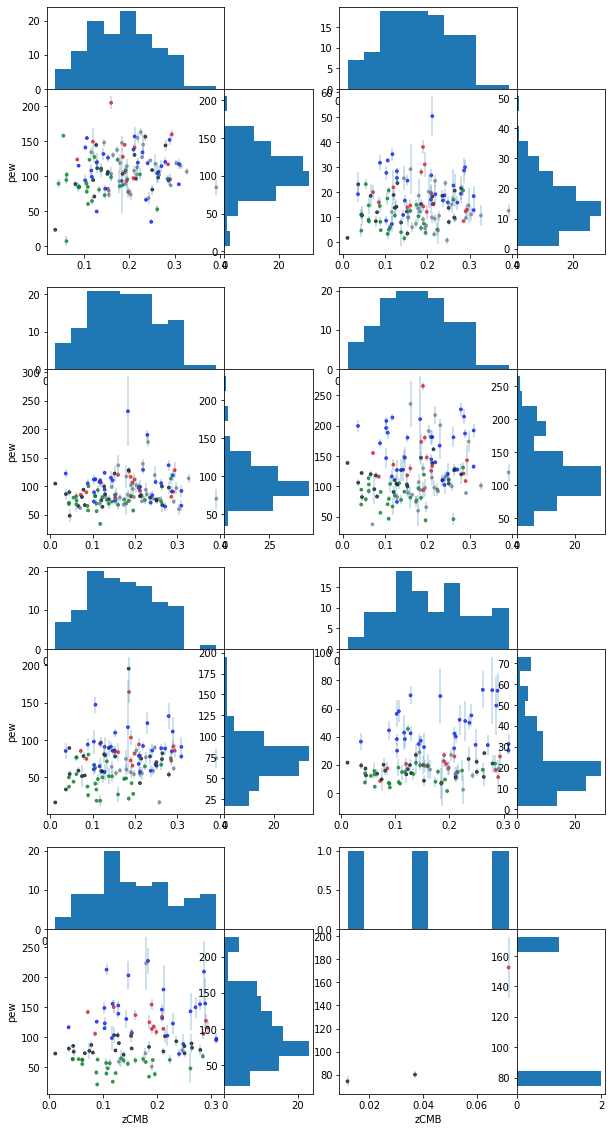

In [15]:
#KF, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'zCMB', 
    'pew', 
    'pew_samperr')


In [16]:
# redshift vel
print(outlier_finder(sdss_combined, 'pW1', 'zCMB', 'vel', 0, 0.1, -20000, 0))
print(outlier_finder(sdss_combined, 'pW3', 'zCMB', 'vel', 0.2, 0.3, 16000, 40000))
print(outlier_finder(sdss_combined, 'pW4', 'zCMB', 'vel', 0, 0.5, 25000, 40000))
print(outlier_finder(sdss_combined, 'pW6', 'zCMB', 'vel', 0, 0.5, 15000, 40000))

 16280
 13072
 16333
 6933


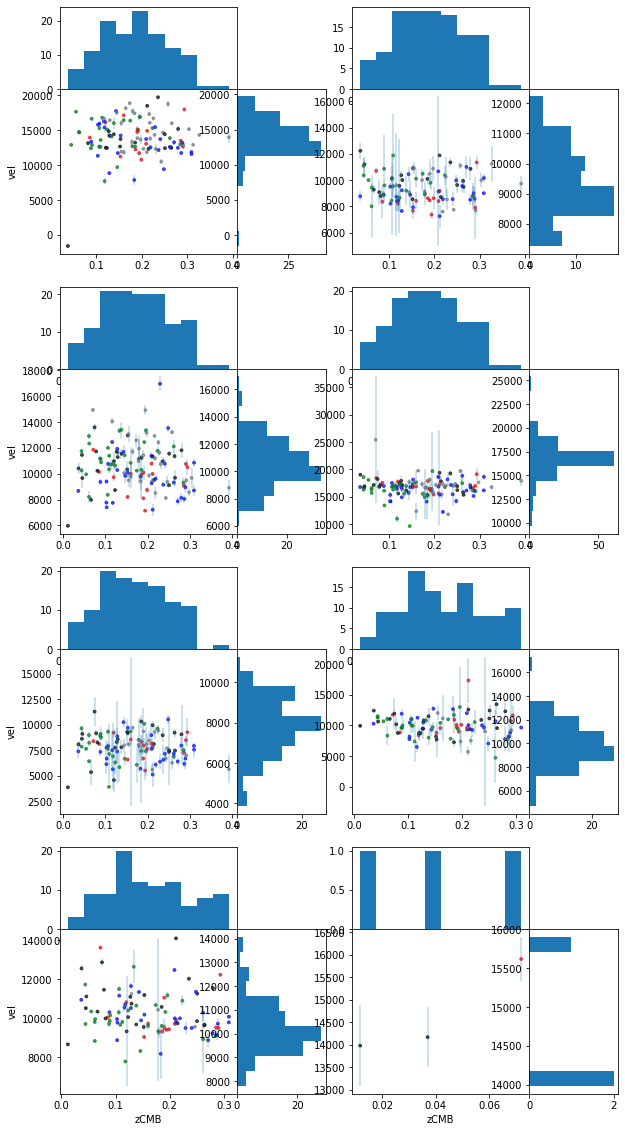

In [17]:
#KF, velocity
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'zCMB', 
    'vel', 
    'vel_samperr')

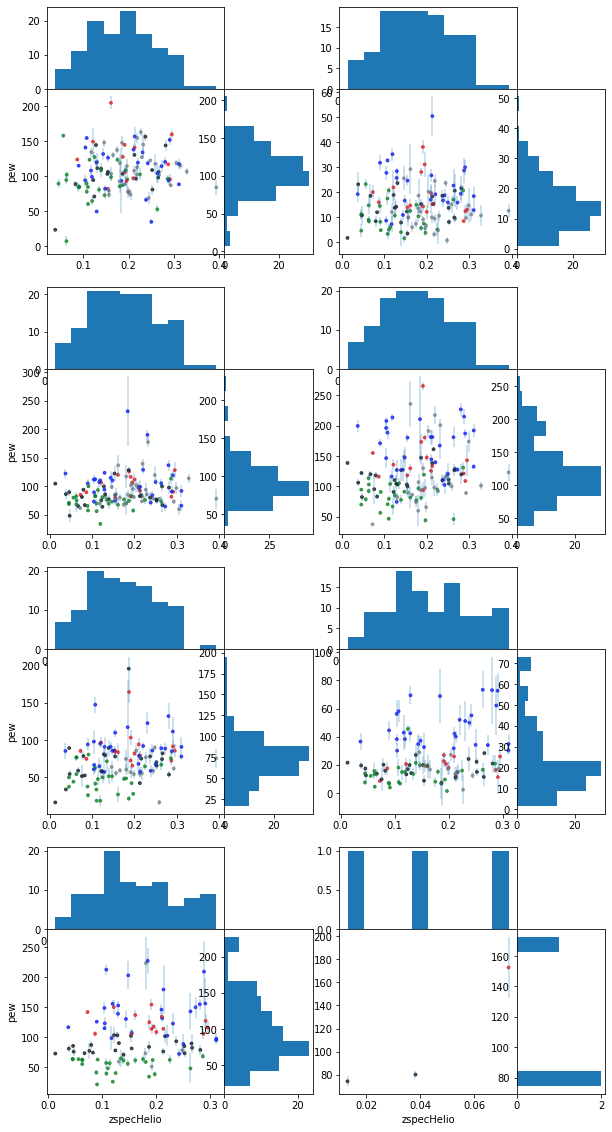

In [18]:
#RF, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'zspecHelio', 
    'pew', 
    'pew_samperr')

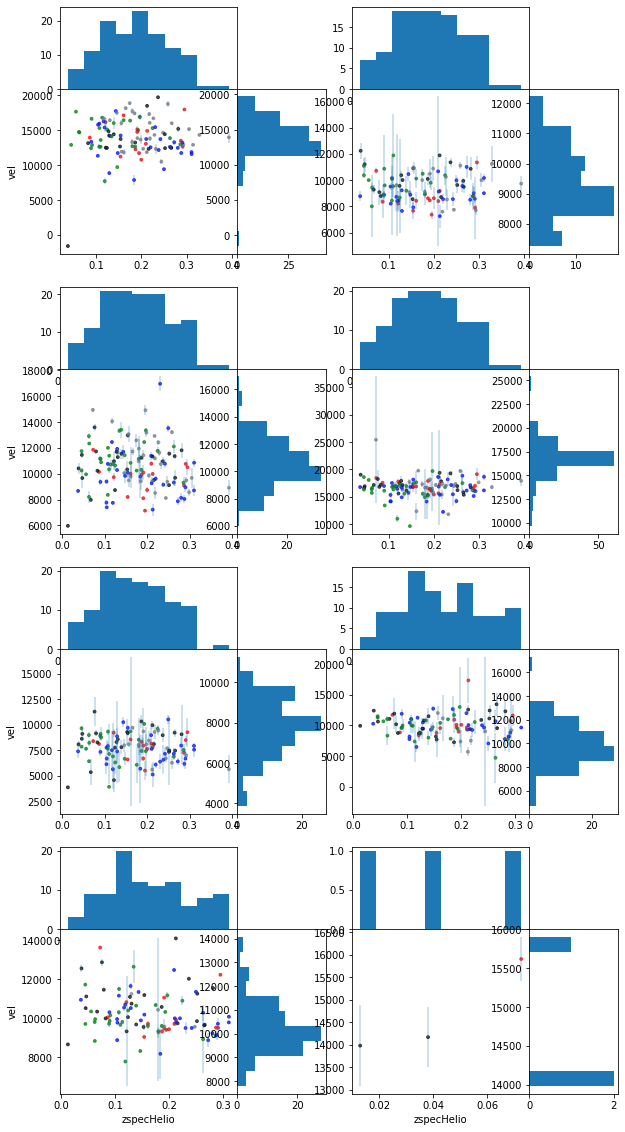

In [19]:
#RF, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'zspecHelio', 
    'vel', 
    'vel_samperr')

# host mass

In [ ]:
# host mass pew
print(outlier_finder(sdss_combined, 'pW1', 'logMassFSPS', 'pew', 0, 11, 0, 25))
print(outlier_finder(sdss_combined, 'pW2', 'logMassFSPS', 'pew', 0, 11, 45, 500))
print(outlier_finder(sdss_combined, 'pW3', 'logMassFSPS', 'pew', 0, 50, 150, 500))
print(outlier_finder(sdss_combined, 'pW5', 'logMassFSPS', 'pew', 0, 50, 175, 500))

In [ ]:
# FSPS, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logMassFSPS', 
    'pew', 
    'pew_samperr')

In [ ]:
# host mass vel
print(outlier_finder(sdss_combined, 'pW1', 'logMassFSPS', 'vel', 0, 11, -20000, 0))
print(outlier_finder(sdss_combined, 'pW3', 'logMassFSPS', 'vel', 0, 50, 16000, 50000))
print(outlier_finder(sdss_combined, 'pW4', 'logMassFSPS', 'vel', 0, 50, 22500, 50000))

In [ ]:
#FSPS, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logMassFSPS', 
    'vel', 
    'vel_samperr')

In [ ]:
# PEGASE, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logMassPEGASE', 
    'pew', 
    'pew_samperr')

In [ ]:
# PEGASE, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logMassPEGASE', 
    'vel', 
    'vel_samperr')

# SFR

In [ ]:
#SSFR pew
print(outlier_finder(sdss_combined, 'pW3', 'logSSFRFSPS', 'pew', -18, -16, 200, 250))
print(outlier_finder(sdss_combined, 'pW6', 'logSSFRFSPS', 'pew', -18, -16, 60, 80))

In [ ]:
#FSPS, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logSSFRFSPS', 
    'pew', 
    'pew_samperr')

In [ ]:
#SSFR vel
print(outlier_finder(sdss_combined, 'pW1', 'logSSFRFSPS', 'vel', -18, -12, -20000, 0))
print(outlier_finder(sdss_combined, 'pW4', 'logSSFRFSPS', 'vel', -18, -10, 22500, 500000))

In [ ]:
#FSPS, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logSSFRFSPS', 
    'vel', 
    'vel_samperr')

In [ ]:
# FSPS, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logSSFRFSPS', 
    'pew', 
    'pew_samperr')

In [ ]:

#PEGASE, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logSFRPEGASE', 
    'pew', 
    'pew_samperr')

In [ ]:
#PEGASE, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logSFRPEGASE', 
    'vel', 
    'vel_samperr')

# Age

In [ ]:
#FSPS, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'ageFSPS', 
    'pew', 
    'pew_samperr')

In [ ]:
#FSPS, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'ageFSPS', 
    'vel', 
    'vel_samperr')

In [ ]:
#PEGASE, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'agePEGASE', 
    'pew', 
    'pew_samperr')

In [ ]:
#PEGASE, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'agePEGASE', 
    'vel', 
    'vel_samperr')

# vel

In [ ]:
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'vel', 
    'pew', 
    'pew_samperr')

# distance from SN to host reg, norm

In [ ]:
# pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'kpc', 
    'pew', 
    'pew_samperr')

In [ ]:
#vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'kpc', 
    'vel', 
    'vel_samperr')

In [ ]:
def pearson_list(df, features, xcol, ycol):
    """Creates lists of pearson statistic p and c values for each feature for any two given columns
        used in pearson_table_make function
    
    Args:
        df     (DataFrame): The dataframe in which the columns we want to compare are
        features (List[str]): The feature ids to add to table
        xcol           (str): Name of one column to compare
        ycol           (str): Name of second column to compare
    
    Returns:
        p_list   (List[float]): List of P values
        c_list   (List[float]): List of c values
    """
    
    p_list = []
    c_list = []
    
    for feat in zip(features):
        feat_data = df.loc[feat]
        x = feat_data[xcol]
        y = feat_data[ycol]
        
        no_nan = (np.isfinite(x) & np.isfinite(y))
        
        if len(x[no_nan]) >= 3:
            corr, p = pearsonr(x[no_nan], y[no_nan])
            p_list.append(p)
            c_list.append(corr)
            
        else:
            p_list.append(np.nan)
            c_list.append(np.nan)
        
    return p_list, c_list
        

In [ ]:
def pearson_table_make(df, features):
    """Creates data frame of p and c pearson stat values for specific columns vs. pew and vel
    
    Args:
        df     (DataFrame): The dataframe in which the columns we want to compare are
        features (List[str]): The feature ids to add to table 
        
    Returns:
        data    (DataFrame): Table of p and c values for different qualities vs pew and vel.
    """
        
    data = pd.DataFrame()
    data['features'] = features
    
    df = df_col = df[['zCMB','zspecHelio','logMassFSPS','logSSFRFSPS',
                      'ageFSPS','kpc', 'pew','vel']]
    df_col = df[['zCMB','zspecHelio','logMassFSPS','logSSFRFSPS'
                 ,'ageFSPS','kpc',]]
    
    for column in df_col:
        p_pew, c_pew = pearson_list(df, features, column , 'pew')
        data[f'{column}_c_pew'] = c_pew
        data[f'{column}_p_pew'] = p_pew
        p_vel, c_vel = pearson_list(df, features, column, 'vel')
        data[f'{column}_c_vel'] = c_vel
        data[f'{column}_p_vel'] = p_vel
    
    data = data.set_index('features')
    return data

In [ ]:
features = [f'pW{i}' for i in range(1, 9)]
pearson_table = pearson_table_make(sdss_combined, features)
pearson_table.to_csv(results_dir / 'pearson_table.csv')

pearson_table

In [ ]:
sdss_cl = sdss_combined[sdss_combined['branch_type'] == 'CL']
sdss_bl = sdss_combined[sdss_combined['branch_type'] == 'BL']
sdss_cn = sdss_combined[sdss_combined['branch_type'] == 'CN']
sdss_ss = sdss_combined[sdss_combined['branch_type'] == 'SS']

In [ ]:
features = [f'pW{i}' for i in range(1, 9)]
bl_pearson_table = pearson_table_make(sdss_bl, features)
bl_pearson_table.to_csv(results_dir / 'bl_pearson_table.csv')
bl_pearson_table

In [ ]:
features = [f'pW{i}' for i in range(1, 9)]
cn_pearson_table = pearson_table_make(sdss_cn, features)
cn_pearson_table.to_csv(results_dir / 'cn_pearson_table.csv')
cn_pearson_table

In [ ]:
features = [f'pW{i}' for i in range(1, 8)]
cl_pearson_table = pearson_table_make(sdss_cl, features)
cl_pearson_table.to_csv(results_dir / 'cl_pearson_table.csv')
cl_pearson_table

In [ ]:
features = [f'pW{i}' for i in range(1, 8)]
ss_pearson_table = pearson_table_make(sdss_ss, features)
ss_pearson_table.to_csv(results_dir / 'ss_pearson_table.csv')
ss_pearson_table